## DISASTER TWEETS CLASSIFICATION USING MACHINE LEARNING



Table of Contents

Dependancies and Dataset

Data Exploration

Data Cleaning

Extra Data Exploration and Analysis on Cleaned Text

Spliting data

Machine Learning Models

Comparing accuracies of all models

Conclusion

## 1 Dependencies and Dataset

## 1.1 Importing Dependencies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

#libraries for NLP
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud,STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython.display import HTML
!pip install chart_studio
import plotly
import plotly.graph_objs as go
import chart_studio.plotly as py
import plotly.figure_factory as ff
from plotly.offline import iplot
plotly.offline.init_notebook_mode(connected=True)
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
import plotly.express as px
from collections import defaultdict
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

## 1.2 Reading and preparation of data

Reading [data](https://www.kaggle.com/c/nlp-getting-started/data) and choosing important columns using [pandas](https://pandas.pydata.org/)

In [2]:
data = pd.read_csv('twitter_disaster.csv')

Displaying first 10 rows of our data using [DataFrame.head()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html)

In [3]:
data.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


Concise summarization of total information provided by the data using [DataFrame.info()](https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.DataFrame.info.html)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


We only use text and target column of dataset for rest of our work as there lot's of null values inside other columns

In [5]:
data = data[['text','target']]
data.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


## 2. Data Exploration

## 2.1 Visualising counts of real and fake tweets

Let's plot the counts of values under the target column

In [6]:
fig = px.bar(x=["0","1"], y=data["target"].value_counts(),color=["red", "goldenrod"])

#Change this value for bar widths
for dt in fig.data:
    dt["width"] = 0.4 

fig.update_layout(
    title_text = "Counts for Disaster and Non-Disaster Tweets",
    title_x=0.5,
    width=800,
    height=550,
    xaxis_title="Targets",
    yaxis_title="Count",
    showlegend=False
).show()

# py.plot(fig,filename='Counts for Disaster and Non-Disaster Tweets',auto_open=False,show_link=False)

The plot shows that our data is quite balanced, you can also click on the plot to explore more about [interactive plots](https://plotly.com/) 

## 2.2 Visualising lengths of tweets

Analyzing lengths of words in a tweets according to it being real or fake target value by ploting [histograms](https://plotly.com/python/histograms/)

In [7]:
from plotly.subplots import make_subplots

word_len_dis = data[data['target']==1]['text'].str.split().map(lambda x : len(x))

word_len_non_dis = data[data['target']==0]['text'].str.split().map(lambda x : len(x))

fig = make_subplots(rows=1, cols=2,subplot_titles=("Disaster Tweets", "Non-Disaster Tweets"))

fig.add_trace(
            go.Histogram(x=word_len_dis,marker_line=dict(color='black'),marker_line_width=1.2),
            row=1, col=1
).add_trace(
            go.Histogram(x=word_len_non_dis,marker_line=dict(color='black'),marker_line_width=1.2),
            row=1, col=2
).update_layout(title_text="Length of words in Tweets",title_x=0.5,showlegend=False).show()

# py.plot(fig,filename='Length of words in Tweets',auto_open=False,show_link=False)

From the plot we can say that the number of words in the tweets ranges from 2 to 30 in both cases

## 2.3 Visualising average word lengths of tweets

Checking average word length for both type of tweets

In [8]:
def avgwordlen(strlist):
    sum=[]
    for i in strlist:
        sum.append(len(i))
    return sum

avgword_len_dis = data[data['target']==1]['text'].str.split().apply(avgwordlen).map(lambda x: np.mean(x))

avgword_len_non_dis = data[data['target']==0]['text'].str.split().apply(avgwordlen).map(lambda x: np.mean(x))

group_labels = ['Disaster', 'Non-Disaster']
colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

fig = ff.create_distplot([avgword_len_dis, avgword_len_non_dis], group_labels, bin_size=.2, colors=colors,)

fig.update_layout(title_text="Average word length in tweets",title_x=0.5,xaxis_title="Text",yaxis_title="Density").show()

# py.plot(fig,filename='Average word length in tweets',auto_open=False,show_link=False)

From the distplot average word countss for real disaster tweets are found to be in the range(5-7.5)                 
while for fake disaster tweets are in the range of (4-6).

## 2.4 Visualising most common stop words in the text data


### What is a corpus?

In linguistics and NLP, corpus (literally Latin for body) refers to a collection of texts.   
Such collections may be formed of a single language of texts, or can span multiple languages
   
Function for creating sample [corpus](https://21centurytext.wordpress.com/home-2/special-section-window-to-corpus/what-is-corpus/) for further analysis.    

In [9]:
def create_corpus(target):
    corpus = []
    for i in data[data['target']==target]['text'].str.split():
        for x in i:
            corpus.append(x)
    return corpus

### What are stopwords?

In computing, stop words are words that are filtered out before or after the natural language data (text) are processed.       
While “stop words” typically refers to the most common words in a language, all-natural language processing tools don't use a single universal list of stop words.  

Analysing most occuring stop words in the text using corpus creating function(create_corpus)

In [10]:
values_list = []

def analyze_stopwords(data,func,targetlist):
  
  for label in range(0,len(targetlist)):
    corpus = func(targetlist[label])
    dic = defaultdict(int)
    
    for word in corpus:
        dic[word] += 1
    
    top = sorted(dic.items(),key = lambda x: x[1],reverse=True)[:10]
    x_items,y_values = zip(*top)
    values_list.append(x_items)
    values_list.append(y_values)

#analyzing stopwords for 0 and 1 target labels
analyze_stopwords(data,create_corpus,[0,1])

fig = make_subplots(rows=1, cols=2,subplot_titles=("Disaster Tweets", "Non-Disaster Tweets"))

fig.add_trace(
      go.Bar(x=values_list[1],y=values_list[0],orientation='h',marker=dict(color= 'rgba(152, 255, 74,0.8)'),
             marker_line=dict(color='black'),marker_line_width=1.2),
      row=1, col=1
).add_trace(
      go.Bar(x=values_list[3],y=values_list[2],orientation='h',marker=dict(color= 'rgba(255, 143, 92,0.8)'),
             marker_line=dict(color='black'),marker_line_width=1.2),
      row=1, col=2
).update_layout(title_text="Top stop words in the text",title_x=0.5,showlegend=False).show()

# py.plot(fig,filename='Top stop words in the text',auto_open=False,show_link=False)

The Bar Charts displays the top 10 stop words in tweets where **'the'** is most frequent in both groups

## 2.5 Visualising most common punctuations in the text data

Now let's have a look at the punctuations inside our data

In [11]:
#The above Bar Charts displays the top 10 stop words in tweets where the occurs the most in both groups
# Anaysing Punctuations
from string import punctuation
values_list = []
def analyze_punctuations(data,func,targetlist):
  
  for label in range(0,len(targetlist)):
    corpus = func(targetlist[label])
    dic = defaultdict(int)
    
    for word in corpus:
        if word in punctuation:
            dic[word] += 1 
    x_items, y_values = zip(*dic.items())
    values_list.append(x_items)
    values_list.append(y_values)

#analyzing punctuations for 0 and 1 target labels
analyze_punctuations(data,create_corpus,[0,1])

fig = make_subplots(rows=1, cols=2,subplot_titles=("Disaster Tweets", "Non-Disaster Tweets"))
  
fig.add_trace(
      go.Bar(x=values_list[0],y=values_list[1],
             marker=dict(color= 'rgba(196, 94, 255,0.8)'),
             marker_line=dict(color='black'),marker_line_width=1.2),
      row=1, col=1
).add_trace(
      go.Bar(x=values_list[2],y=values_list[3],
             marker=dict(color= 'rgba(255, 163, 102,0.8)'),
             marker_line=dict(color='black'),marker_line_width=1.2),
      row=1, col=2
).update_layout(title_text="Top Punctuations in the text",title_x=0.5,showlegend=False).show()

# py.plot(fig,filename='Top Punctuations in the text',auto_open=False,show_link=False)

# 3. Data Cleaning

## 3.1 Removing unwanted text using regular expressions

### What is Stemming?  
Stemming is the process of reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words known as a lemma.   
Stemming is important in natural language understanding (NLU) and natural language processing (NLP). Here we use SnowballStemmer.

Function for cleaning the data, we use RegEx i.e. re python library and SnowballStemmer() to stem the words.

In [12]:
stemmer = SnowballStemmer("english")

def preprocess_data(data):
    
    #removal of url
    text = re.sub(r'https?://\S+|www\.\S+|http?://\S+',' ',data) 
    
    #decontraction
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)    
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    
    #removal of html tags
    text = re.sub(r'<.*?>',' ',text) 
    
    # Match all digits in the string and replace them by empty string
    text = re.sub(r'[0-9]', '', text)
    text = re.sub("["
                           u"\U0001F600-\U0001F64F"  # removal of emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+",' ',text)
    
    # filtering out miscellaneous text.
    text = re.sub('[^a-zA-Z]',' ',text) 
    text = re.sub(r"\([^()]*\)", "", text)
    
    # remove mentions
    text = re.sub('@\S+', '', text)  
    
    # remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), '', text)  
    

    # Lowering all the words in text
    text = text.lower()
    text = text.split()
    
    text = [stemmer.stem(words) for words in text if words not in stopwords.words('english')]
    
    # Removal of words with length<2
    text = [i for i in text if len(i)>2] 
    text = ' '.join(text)
    return text

data["Cleaned_text"] = data["text"].apply(preprocess_data)

Displaying Cleaned Data 

In [13]:
data.head()

,text,target,Cleaned_text
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak may allah forgiv
1,Forest fire near La Ronge Sask. Canada,1,forest fire near rong sask canada
2,All residents asked to 'shelter in place' are ...,1,resid ask ishelt place notifi offic evacu shel...
3,"13,000 people receive #wildfires evacuation or...",1,peopl receiv wildfir evacu order california
4,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo rubi alaska smoke wildfir pour ...


# 4. Extra Data Exploration and Analysis on Cleaned Text

## 4.1  Creating function and data for visualising words

Using the popular WordCloud ython library for visulaising the cleaned data

In [14]:
def wordcloud(data,title):
    words = ' '.join(data['Cleaned_text'].astype('str').tolist())
    stopwords = set(STOPWORDS)
    wc = WordCloud(stopwords = stopwords,width= 512, height = 512).generate(words)
    plt.figure(figsize=(10,8),frameon=True)
    plt.imshow(wc)
    plt.axis('off')
    plt.title(title,fontsize=20)
    plt.show()
    
data_disaster = data[data['target'] == 1]
data_non_disaster = data[data['target'] == 0]

## 4.2 Visualising words inside Real Disaster Tweets

we can see that most common words in disaster tweets are fire,storm,flood , police etc. 

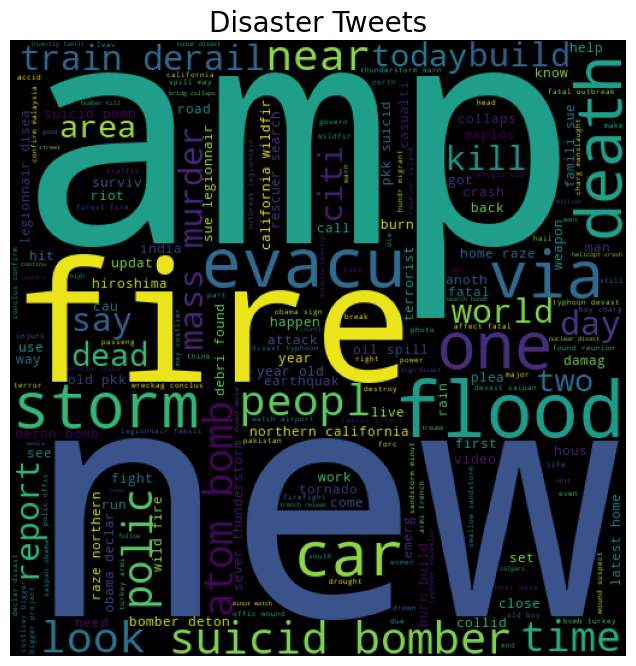

In [15]:
wordcloud(data_disaster,"Disaster Tweets")

## 4.3 Visualising words inside Fake Disaster Tweets

love,new,time etc are the most common words as we can see in wordcloud of Non-disaster tweets

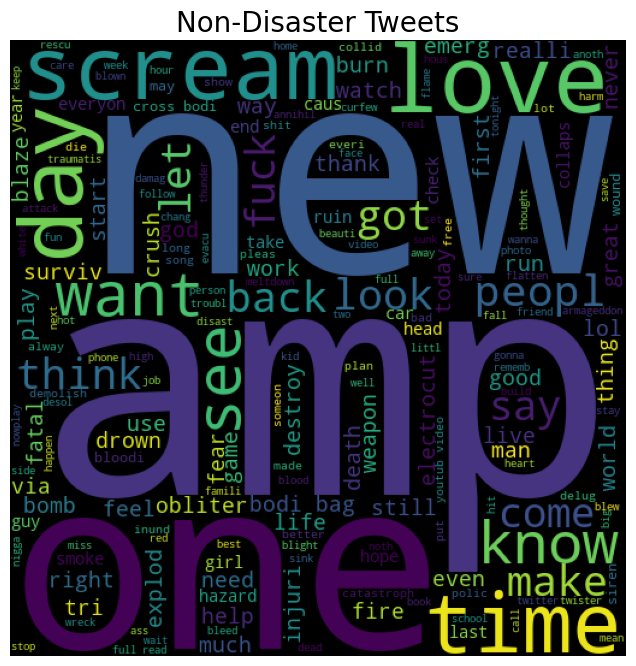

In [16]:
wordcloud(data_non_disaster,"Non-Disaster Tweets")

## 4.4 Removing unwanted words with high frequency

Our cleaned text still contains some unnecessary words (such as: like, amp, get, would etc.) that aren't relevant and can confuse our model,    
resulting in false prediction. Now, we will further remove some words with high frequency from text based on above charts.

In [17]:
common_words = ['via','like','build','get','would','one','two','feel','lol','fuck','take','way','may','first','latest'
                'want','make','back','see','know','let','look','come','got','still','say','think','great','pleas','amp']

def text_cleaning(data):
    return ' '.join(i for i in data.split() if i not in common_words)

data["Cleaned_text"] = data["Cleaned_text"].apply(text_cleaning)

## 4.5 Analysing top 10 N-grams where N is 1,2,3

### What do you mean by N-grams?  
N-grams of texts are extensively used in text mining and natural language processing tasks.     They are basically a set of co-occurring words within a given window and when computing the n-grams you typically move one word forward (although you can move X words forward in more advanced scenarios).  

Below we perform N-grams analysis on cleaned data

In [18]:
def top_ngrams(data,n,grams):
    count_vec = CountVectorizer(ngram_range=(grams,grams)).fit(data)
    bow = count_vec.transform(data)
    add_words = bow.sum(axis=0)
    word_freq = [(word, add_words[0, idx]) for word, idx in count_vec.vocabulary_.items()]
    word_freq = sorted(word_freq, key = lambda x: x[1], reverse=True) 
    return word_freq[:n]

Creating data of top 10 n-grams for n = 1, 2, 3

In [19]:
common_uni = top_ngrams(data["Cleaned_text"],10,1)
common_bi = top_ngrams(data["Cleaned_text"],10,2)
common_tri = top_ngrams(data["Cleaned_text"],10,3)
common_uni_df = pd.DataFrame(common_uni,columns=['word','freq'])
common_bi_df = pd.DataFrame(common_bi,columns=['word','freq'])
common_tri_df = pd.DataFrame(common_tri,columns=['word','freq'])

## 4.6 Visualising top 10 N-grams for N = 1, 2, 3

In [20]:
fig = make_subplots(rows=3, cols=1,subplot_titles=("Top 20 Unigrams in Text", "Top 20 Bigrams in Text","Top 20 Trigrams in Text"))
  
fig.add_trace(
      go.Bar(x=common_uni_df["word"],y=common_uni_df["freq"],
             marker=dict(color= 'rgba(255, 170, 59,0.8)'),
             marker_line=dict(color='black'),marker_line_width=1.2),
      row=1, col=1
).add_trace(
      go.Bar(x=common_bi_df["word"],y=common_bi_df["freq"],
             marker=dict(color= 'rgba(89, 255, 147,0.8)'),
             marker_line=dict(color='black'),marker_line_width=1.2),
      row=2, col=1
).add_trace(
      go.Bar(x=common_tri_df["word"],y=common_tri_df["freq"],
             marker=dict(color= 'rgba(89, 153, 255,0.8)'),
             marker_line=dict(color='black'),marker_line_width=1.2),
      row=3, col=1
).update_layout(title_text="Visualization of Top 20 Unigrams, Bigrams and Trigrams",
                title_x=0.5,showlegend=False,width=800,height=1600,).update_xaxes(tickangle=-90).show()

# py.plot(fig,filename='Visualization of Top 20 Unigrams, Bigrams and Trigrams',auto_open=False,show_link=False)

# 5. Data Preprocessing 

## 5.1 Spliting original data after cleaning 

In [ ]:
X_inp_clean = data['Cleaned_text']
X_inp_original = data['text']
y_inp = data['target']

Using [scikit-learn's train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split the data into training and validation dataset

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_inp_clean, y_inp, test_size=0.2, random_state=42, stratify=y_inp)
y_train = np.array(y_train)
y_valid = np.array(y_valid)

checking size of data after train test split

In [ ]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((6090,), (1523,), (6090,), (1523,))

## 5.2 Creating function to encode data using BoW or TF-IDF

### What is BoW?   
BoW stands for "*bag of words*" which is a representation of text that describes the occurrence of words within a document.   
We just keep track of word counts and disregard the grammatical details and the word order.   
It is called a “bag” of words because any information about the order or structure of words in the document is discarded. 
The model is only concerned with whether known words occur in the document, not where in the document.
    
    
### What is TF-IDF?
TF-IDF which means Term Frequency and Inverse Document Frequency, is a scoring measure widely used in information retrieval (IR) or summarization.     
TF-IDF is intended to reflect how relevant a term is in a given document. It is a technique in Natural Language Processing for converting words in Vectors and with some semantic information and it gives weighted to uncommon words , used in various NLP applications.    

For Bow Countvectorizer and for TF-IDF we use TfidfVectorizer

In [ ]:
def encoding(train_data,valid_data,bow=False,n=1,tf_idf=False):
    if bow==True:
        cv = CountVectorizer(ngram_range=(n,n))
        cv_df_train = cv.fit_transform(train_data).toarray()
        train_df = pd.DataFrame(cv_df_train,columns=cv.get_feature_names_out())
        cv_df_valid = cv.transform(valid_data).toarray()
        valid_df = pd.DataFrame(cv_df_valid,columns=cv.get_feature_names_out())
            
    elif tf_idf==True:
        
        tfidf = TfidfVectorizer(ngram_range=(n, n), use_idf=1,smooth_idf=1,sublinear_tf=1)    
        tf_df_train = tfidf.fit_transform(train_data).toarray()
        train_df = pd.DataFrame(tf_df_train,columns=tfidf.get_feature_names_out())
        tf_df_valid = tfidf.transform(valid_data).toarray()
        valid_df = pd.DataFrame(tf_df_valid,columns=tfidf.get_feature_names_out())
        
    return train_df,valid_df 

## 5.3 Encoding training and validation data

We encode our data in all possible combinations provided by our function

In [ ]:
X_train_bow1 , X_valid_bow1 = encoding(X_train,X_valid,bow=True) 
X_train_bow2 , X_valid_bow2 = encoding(X_train,X_valid,bow=True,n=2) 
X_train_bow3 , X_valid_bow3 = encoding(X_train,X_valid,bow=True,n=3) 
X_train_tfidf1 , X_valid_tfidf1 = encoding(X_train,X_valid,tf_idf=True) 
X_train_tfidf2 , X_valid_tfidf2 = encoding(X_train,X_valid,tf_idf=True,n=2) 
X_train_tfidf3 , X_valid_tfidf3 = encoding(X_train,X_valid,tf_idf=True,n=3)

# 6. Training and tuning Machine Learining Models

In [ ]:
def c_report(y_true,y_pred):
    print("Classifictaion Report")
    print(classification_report(y_true, y_pred))
    acc_scr = accuracy_score(y_true, y_pred)
    print("Accuracy : "+ str(acc_scr))
    return acc_scr

def plot_cm(y_true,y_pred,cmap = "Blues"):
    mtx = confusion_matrix(y_true, y_pred)
    sns.heatmap(mtx, annot = True, fmt='d', linewidth=0.5,
               cmap=cmap, cbar = False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

## 6.1 Logistic Regression

In [ ]:
model_bow1_logreg = LogisticRegression()
model_bow1_logreg.fit(X_train_bow1,y_train)
pred_bow1_logreg = model_bow1_logreg.predict(X_valid_bow1)

LogisticRegression()

Printing classification report and ploting confusion matrix for the predictions made by LogisticRegression(BoW,n-grams=1) model

Classifictaion Report
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       869
           1       0.82      0.73      0.77       654

    accuracy                           0.82      1523
   macro avg       0.82      0.81      0.81      1523
weighted avg       0.82      0.82      0.81      1523

Accuracy : 0.8161523309258043


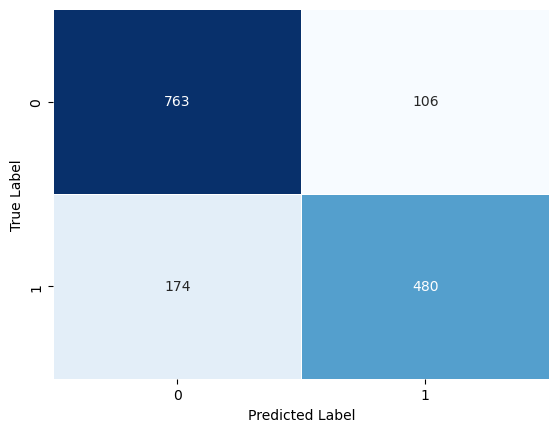

In [ ]:
acc_bow1_logreg = c_report(y_valid,pred_bow1_logreg)
plot_cm(y_valid,pred_bow1_logreg)

Now training another Logistic Regression model with n-grams=2 and BoW 

In [ ]:
model_bow2_logreg = LogisticRegression()
model_bow2_logreg.fit(X_train_bow2,y_train)
pred_bow2_logreg = model_bow2_logreg.predict(X_valid_bow2)

LogisticRegression()

Printing classification report and ploting confusion matrix for the predictions made by LogisticRegression(BoW,n-grams=2) model

Classifictaion Report
              precision    recall  f1-score   support

           0       0.70      0.96      0.81       869
           1       0.89      0.45      0.60       654

    accuracy                           0.74      1523
   macro avg       0.79      0.71      0.70      1523
weighted avg       0.78      0.74      0.72      1523

Accuracy : 0.7406434668417596


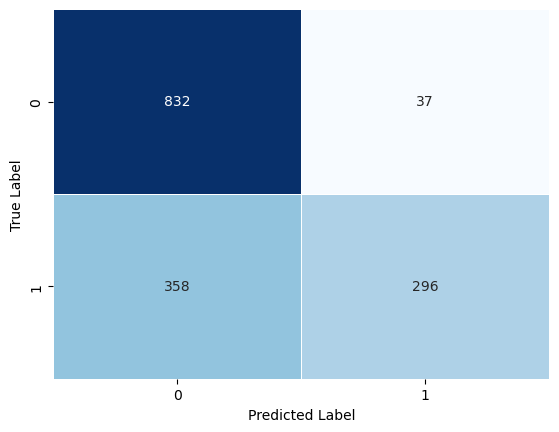

In [ ]:
acc_bow2_logreg = c_report(y_valid,pred_bow2_logreg)
plot_cm(y_valid,pred_bow2_logreg)

We can observe that as n is increasing model accuracy is decreasing   
let's try to increase n one last time just to be sure

In [ ]:
model_bow3_logreg = LogisticRegression()
model_bow3_logreg.fit(X_train_bow3,y_train)
pred_bow3_logreg = model_bow3_logreg.predict(X_valid_bow3)

LogisticRegression()

Printing classification report and ploting confusion matrix for the predictions made by LogisticRegression(BoW,n-grams=3) model

Classifictaion Report
              precision    recall  f1-score   support

           0       0.66      0.98      0.79       869
           1       0.92      0.33      0.49       654

    accuracy                           0.70      1523
   macro avg       0.79      0.65      0.64      1523
weighted avg       0.77      0.70      0.66      1523

Accuracy : 0.7005909389363099


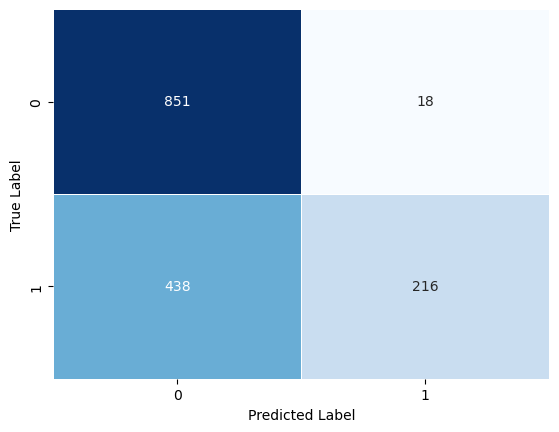

In [ ]:
acc_bow3_logreg = c_report(y_valid,pred_bow3_logreg)
plot_cm(y_valid,pred_bow3_logreg)

From the above results it's clear that using n = 1 will always give us more accuray,  
now let's use tfidf approach with n = 1 to train our Logistic Regression model

In [ ]:
model_tfidf1_logreg = LogisticRegression(C=1.0)
model_tfidf1_logreg.fit(X_train_tfidf1,y_train)
pred_tfidf1_logreg = model_tfidf1_logreg.predict(X_valid_tfidf1)

LogisticRegression()

Printing classification report and ploting confusion matrix for the predictions made by LogisticRegression(TF-IDF,n-grams=1) model

Classifictaion Report
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       869
           1       0.85      0.71      0.77       654

    accuracy                           0.82      1523
   macro avg       0.83      0.81      0.81      1523
weighted avg       0.82      0.82      0.82      1523

Accuracy : 0.8207485226526592


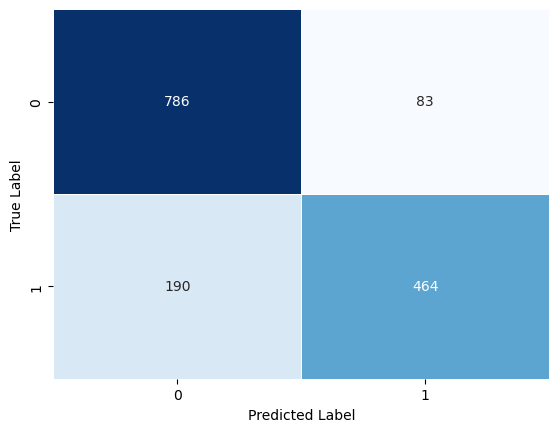

In [ ]:
acc_tfidf1_logreg = c_report(y_valid,pred_tfidf1_logreg)
plot_cm(y_valid,pred_tfidf1_logreg)

From Logistic Regression we saw n-grams = 1 gives the best results 

## 6.2 Multinomial Naive Bayes

In [ ]:
model_bow1_NB = MultinomialNB(alpha=0.7)
model_bow1_NB.fit(X_train_bow1,y_train)
pred_bow1_NB = model_bow1_NB.predict(X_valid_bow1)

MultinomialNB(alpha=0.7)

Printing classification report and ploting confusion matrix  for the predictions of MultinomialNB(BoW,n-grams=1) model

Classifictaion Report
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       869
           1       0.79      0.76      0.78       654

    accuracy                           0.81      1523
   macro avg       0.81      0.80      0.81      1523
weighted avg       0.81      0.81      0.81      1523

Accuracy : 0.8108995403808273


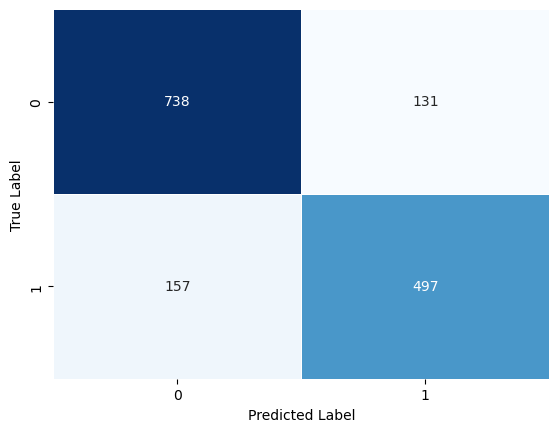

In [ ]:
acc_bow1_NB = c_report(y_valid,pred_bow1_NB)
plot_cm(y_valid,pred_bow1_NB)

Creating a MultinomialNB model and training it with TF-IDF approach

In [ ]:
model_tfidf1_NB = MultinomialNB(alpha=0.7)
model_tfidf1_NB.fit(X_train_tfidf1,y_train)
pred_tfidf1_NB = model_tfidf1_NB.predict(X_valid_tfidf1)

MultinomialNB(alpha=0.7)

Printing classification report and ploting confusion matrix for the predictions of MultinomialNB(TF-IDF,n-grams=1) model

Classifictaion Report
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       869
           1       0.84      0.70      0.76       654

    accuracy                           0.81      1523
   macro avg       0.82      0.80      0.80      1523
weighted avg       0.82      0.81      0.81      1523

Accuracy : 0.8135259356533159


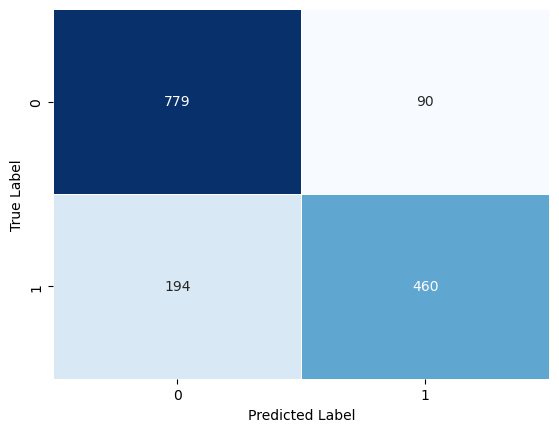

In [ ]:
acc_tfidf1_NB = c_report(y_valid,pred_tfidf1_NB)
plot_cm(y_valid,pred_tfidf1_NB)

## 6.3 Random Forest Classifier

In [ ]:
model_tfidf1_RFC = RandomForestClassifier()
model_tfidf1_RFC.fit(X_train_tfidf1,y_train)
pred_tfidf1_RFC = model_tfidf1_RFC.predict(X_valid_tfidf1)

RandomForestClassifier()

Printing classification report and ploting confusion matrix for predictions of RandomForestClassifier model

Classifictaion Report
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       869
           1       0.82      0.71      0.76       654

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.80      1523

Accuracy : 0.8063033486539725


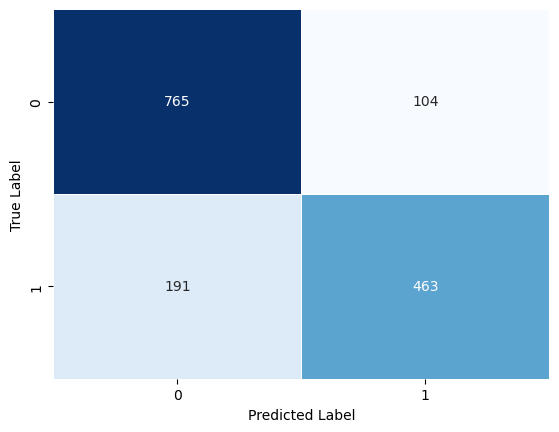

In [ ]:
acc_tfidf1_RFC = c_report(y_valid,pred_tfidf1_RFC)
plot_cm(y_valid,pred_tfidf1_RFC)

## 6.4 eXtreme Gradient Boosting Classifier

In [ ]:
model_tfidf1_XGB = XGBClassifier(eval_metric='mlogloss')
model_tfidf1_XGB.fit(X_train_tfidf1,y_train)
pred_tfidf1_XGB = model_tfidf1_XGB.predict(X_valid_tfidf1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

Printing classification report and ploting confusion matrix for the predictions made by the XGBClassifier model

Classifictaion Report
              precision    recall  f1-score   support

           0       0.78      0.88      0.83       869
           1       0.81      0.66      0.73       654

    accuracy                           0.79      1523
   macro avg       0.79      0.77      0.78      1523
weighted avg       0.79      0.79      0.78      1523

Accuracy : 0.7872619829284307


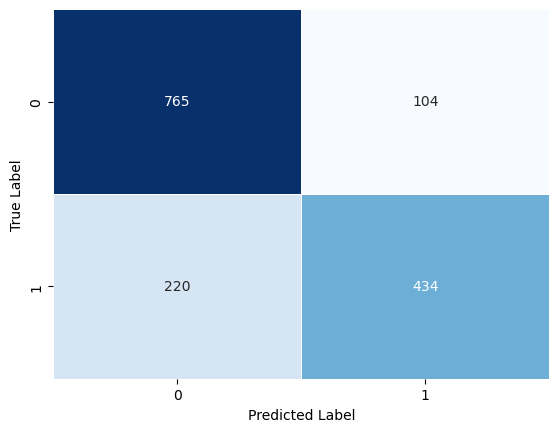

In [ ]:
acc_tfidf1_XGB = c_report(y_valid,pred_tfidf1_XGB)
plot_cm(y_valid,pred_tfidf1_XGB)

## 6.5 CatBoostClassifier

In [ ]:
model_tfidf1_CBC = CatBoostClassifier(iterations=100)
model_tfidf1_CBC.fit(X_train_tfidf1,y_train)
pred_tfidf1_CBC = model_tfidf1_CBC.predict(X_valid_tfidf1)


Learning rate set to 0.184063
0:	learn: 0.6742927	total: 324ms	remaining: 32.1s
1:	learn: 0.6618333	total: 454ms	remaining: 22.2s
2:	learn: 0.6520205	total: 597ms	remaining: 19.3s
3:	learn: 0.6417444	total: 716ms	remaining: 17.2s
4:	learn: 0.6351862	total: 824ms	remaining: 15.7s
5:	learn: 0.6268789	total: 960ms	remaining: 15s
6:	learn: 0.6205555	total: 1.09s	remaining: 14.4s
7:	learn: 0.6149114	total: 1.21s	remaining: 14s
8:	learn: 0.6095348	total: 1.33s	remaining: 13.5s
9:	learn: 0.6053483	total: 1.47s	remaining: 13.3s
10:	learn: 0.6008680	total: 1.6s	remaining: 12.9s
11:	learn: 0.5972103	total: 1.74s	remaining: 12.8s
12:	learn: 0.5937001	total: 1.86s	remaining: 12.4s
13:	learn: 0.5912498	total: 1.99s	remaining: 12.2s
14:	learn: 0.5870390	total: 2.11s	remaining: 12s
15:	learn: 0.5836361	total: 2.34s	remaining: 12.3s
16:	learn: 0.5799069	total: 2.48s	remaining: 12.1s
17:	learn: 0.5762295	total: 2.61s	remaining: 11.9s
18:	learn: 0.5735028	total: 2.74s	remaining: 11.7s
19:	learn: 0.57021

Printing classification report and ploting confusion matrix for the predictions made by the above model

Classifictaion Report
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       869
           1       0.82      0.66      0.73       654

    accuracy                           0.79      1523
   macro avg       0.80      0.78      0.78      1523
weighted avg       0.80      0.79      0.79      1523

Accuracy : 0.793827971109652


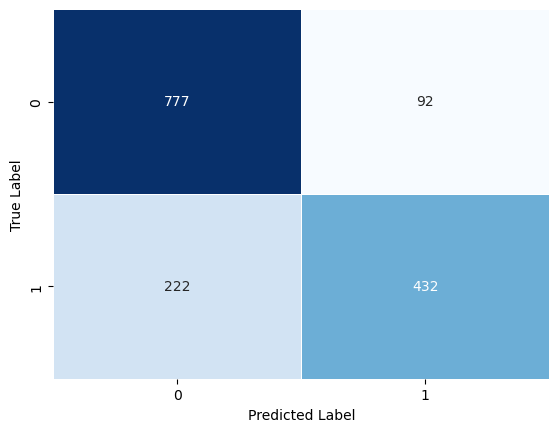

In [ ]:
acc_tfidf1_CBC = c_report(y_valid,pred_tfidf1_CBC)
plot_cm(y_valid,pred_tfidf1_CBC)

## 6.6 Support Vector CLassifier 

In [ ]:
model_tfidf1_SVC = SVC(kernel='linear', degree=3, gamma='auto')
model_tfidf1_SVC.fit(X_train_tfidf1,y_train)
pred_tfidf1_SVC = model_tfidf1_SVC.predict(X_valid_tfidf1)

SVC(gamma='auto', kernel='linear')

Printing classification report and ploting confusion matrix for the SVC model

Classifictaion Report
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       869
           1       0.83      0.74      0.78       654

    accuracy                           0.82      1523
   macro avg       0.82      0.81      0.81      1523
weighted avg       0.82      0.82      0.82      1523

Accuracy : 0.8214051214707814


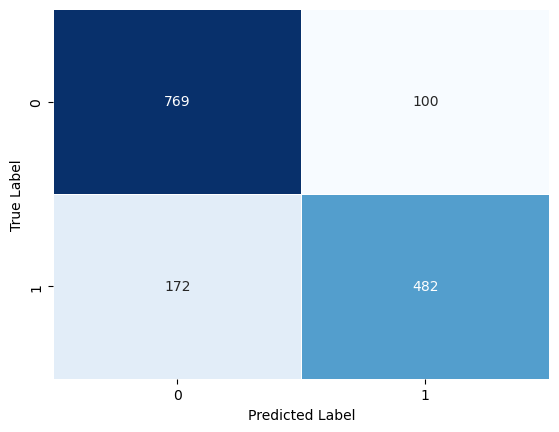

In [ ]:
acc_tfidf1_SVC = c_report(y_valid,pred_tfidf1_SVC)
plot_cm(y_valid,pred_tfidf1_SVC)

## 6.7 Voting Classifier

### About Voting Classifier

A Voting Classifier is a machine learning model that trains on an ensemble of numerous models and predicts an output (class) based on    
their highest probability of chosen class as the output. It simply aggregates the findings of each classifier passed into Voting Classifier    
and predicts the output class based on the highest majority of voting. The idea is instead of creating separate dedicated models and finding the accuracy for each them, we create a single model which trains by these models and predicts output based on their combined majority of voting for each output class.

#### Voting Classifier supports two types of votings :  


* **Hard Voting** : In hard voting, the predicted output class is a class with the highest majority of votes i.e the class    which had the highest probability of being predicted by each of the classifiers. Suppose three classifiers predicted the output class(A, A, B), so here the majority predicted A as output. Hence A will be the final prediction.


* **Soft Voting** : In soft voting, the output class is the prediction based on the average of probability given to that class. Suppose given some input to three models, the prediction probability for class A = (0.30, 0.47, 0.53) and B = (0.20, 0.32, 0.40). So the average for class A is 0.4333 and B is 0.3067, the winner is clearly class A because it had the highest probability averaged by each classifier
 


In [ ]:
estimators = []
estimators.append(('LR', 
                  LogisticRegression()))
estimators.append(('NB', MultinomialNB(alpha=0.7)))
estimators.append(('XBG', XGBClassifier(eval_metric='mlogloss')))

model_tfidf1_VC = VotingClassifier(estimators=estimators,voting='soft')
model_tfidf1_VC.fit(X_train_tfidf1,y_train)
pred_tfidf1_VC = model_tfidf1_VC.predict(X_valid_tfidf1)

VotingClassifier(estimators=[('LR', LogisticRegression()),
                             ('NB', MultinomialNB(alpha=0.7)),
                             ('XBG',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='mlogloss',
                                            feature_types=None, gamma=None,
                                            grow_policy=...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                 voting='soft')

Printing classification report and ploting confusion matrix for VotingClasssifier

Classifictaion Report
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       869
           1       0.87      0.71      0.78       654

    accuracy                           0.83      1523
   macro avg       0.84      0.82      0.82      1523
weighted avg       0.84      0.83      0.83      1523

Accuracy : 0.8319107025607354


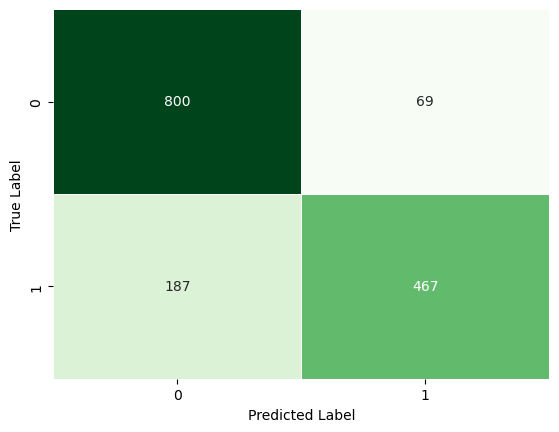

In [ ]:
acc_tfidf1_VC = c_report(y_valid,pred_tfidf1_VC)
plot_cm(y_valid,pred_tfidf1_VC,cmap = "Greens")

# 7. Comparing the Accuracy of all models

In [ ]:
results = pd.DataFrame([["Logistic Regression BoW1",acc_bow1_logreg],["Logistic Regression BoW2",acc_bow2_logreg],
                       ["Logistic Regression BoW3",acc_bow3_logreg],["Logistic Regression Tf-Idf1",acc_tfidf1_logreg],
                       ["Naive Bayes Tf-Idf1",acc_tfidf1_NB],["Random Forest Tf-Idf1",acc_tfidf1_RFC],
                       ["XGBClassifier Tf-Idf1",acc_tfidf1_XGB],["CatBoost Tf-Idf1",acc_tfidf1_CBC],
                        ["SVC Tf-Idf1",acc_tfidf1_SVC],["Voting Tf-Idf1",acc_tfidf1_VC]],
                       columns = ["Models","Accuracy Score"]).sort_values(by='Accuracy Score',ascending=False)

results.style.background_gradient(cmap='Blues')

,Models,Accuracy Score
9,Voting Tf-Idf1,0.831911
8,SVC Tf-Idf1,0.821405
3,Logistic Regression Tf-Idf1,0.820749
0,Logistic Regression BoW1,0.816152
4,Naive Bayes Tf-Idf1,0.813526
5,Random Forest Tf-Idf1,0.806303
7,CatBoost Tf-Idf1,0.793828
6,XGBClassifier Tf-Idf1,0.787262
1,Logistic Regression BoW2,0.740643
2,Logistic Regression BoW3,0.700591


# 8. Conclusion

Among all Simple classification models used above Voting Classifier performed best with tf-idf and ngrams = 1

# **Deep Learning approach to predict real or fake tweets about disaster**


## 1.  Spliting original data after cleaning 

In [22]:
#original data after cleaning 
X_inp_clean = data['Cleaned_text']
X_inp_original = data['text']
y_inp = data['target']

## 2 Data preprocessing and creating padded sentences

### What is Tokenization  

Tokenization is essentially splitting a phrase, sentence, paragraph, or an entire text document into smaller units,  
such as individual words or terms. Each of these smaller units are called tokens.  

The tokens could be words, numbers or punctuation marks. In tokenization, smaller units are created by  
locating word boundaries, which are the ending point of a word and the beginning of the next word. 

Now we use keras text preprocessing Tokenizer to fit on text on Cleaned data

In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer  # Import the Tokenizer class


In [24]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_inp_clean.values)
vocab_length = len(word_tokenizer.word_index) + 1

Creating padded sentences using pad_sequences function

In [25]:
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [26]:
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

longest_train = max(X_inp_clean.values, key=lambda sentence: len(word_tokenize(sentence)))

length_long_sentence = len(word_tokenize(longest_train))

padded_sentences = pad_sequences(embed(X_inp_clean.values), 
                                 length_long_sentence, padding='post')

## Using Glove word embeddings for creating Embedding Matrix

### Why Glove?

The advantage of GloVe is that, unlike Word2vec, GloVe does not rely just on local statistics (local context information of words),   
but incorporates global statistics (word co-occurrence) to obtain word vectors

Creating Embedding dictionary using Glove Twitter data

In [27]:
embeddings_dictionary = dict()

embedding_dim = 100

glove_file = open('glove.6B.100d.txt')

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()

Creating Word Embedding matrix which is a list of all words and their corresponding embeddings.

In [28]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    
    embedding_vector = embeddings_dictionary.get(word)
    
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

## Spliting data into training and validation dataset

Using scikit-learn's train_test_split to split the data into training and validation dataset

In [29]:
X_train, X_val, y_train, y_val = train_test_split(padded_sentences,
                                                  y_inp.values,test_size=0.2,random_state=1)

# Training and Tuning Deep Learning Models

Function to summarise history of train our model

In [30]:
def model_history(model_history):
    fig,(ax1,ax2) =  plt.subplots(1,2,figsize=(12,5))
    
    # summarize history for accuracy
    ax1.plot(model_history.history['accuracy'])
    ax1.plot(model_history.history['val_accuracy'])
    ax1.set_title('model accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'test'], loc='upper right')

    # summarize history for loss
    ax2.plot(model_history.history['loss'])
    ax2.plot(model_history.history['val_loss'])
    ax2.set_title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'test'], loc='upper right')
    
    fig.suptitle("Model History")
    

## Training and Tuning Convolutional Neural Network

In [ ]:
def CNN(hp):
    
    model = keras.Sequential()
    
    hp_learning_rate = hp.Choice('learning_rate', values=[3e-2, 3e-3, 3e-4, 3e-5])
    
    model.add(Embedding(vocab_length, 100, weights=[embedding_matrix],
                                     input_length=length_long_sentence,trainable=False))
    
    model.add(Conv1D(filters=hp.Int('conv_1_filter',min_value=21,max_value=200,step=14),
                                kernel_size=hp.Choice('conv_1_kernel',values=[3,4,5]),
                                activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(MaxPooling1D(pool_size=2))
  
    model.add(Flatten())

    model.add(Dense(units = hp.Int('dense_1',min_value=21,max_value=150,step=14),
                                   activation='relu'))
    
    model.add(Dropout(0.5))
    
    model.add(Dense(1,activation='sigmoid'))
  
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
  
    return model

Creating a tuner using Keras-Tuner(kt) for above function

In [31]:
import keras_tuner as kt
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Embedding





In [ ]:
tuner_CNN = kt.Hyperband(CNN,objective='val_accuracy',
                         max_epochs=15,factor=5,
                         directory='my_dir',
                         project_name='DisasterTweets_kt',
                         overwrite=True)

Searching for a model with highest accuracy and saving it's hyperparameters

In [32]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint


In [ ]:
stop_early = EarlyStopping(monitor='val_loss', mode='min',
                           verbose=1, patience=10)

tuner_CNN.search(X_train, y_train, epochs=15,
                 validation_data=(X_val,y_val),callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps_CNN=tuner_CNN.get_best_hyperparameters(num_trials=1)[0]

Trial 13 Complete [00h 00m 42s]
val_accuracy: 0.7268549203872681

Best val_accuracy So Far: 0.7820091843605042
Total elapsed time: 00h 05m 26s


Creating a model using the best hyperparameters and training it using callbacks to save  the model at appropriate epoch

In [ ]:
model_CNN = tuner_CNN.hypermodel.build(best_hps_CNN)

checkpoint = ModelCheckpoint(
    'model_CNN.keras', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)

model_CNN = tuner_CNN.hypermodel.build(best_hps_CNN)


history_CNN = model_CNN.fit(X_train, y_train,epochs=50,
                            validation_data=(X_val,y_val),
                            callbacks=[checkpoint,stop_early])

Epoch 1/50
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6783 - loss: 0.6085
Epoch 1: val_loss improved from inf to 0.52172, saving model to model_CNN.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6790 - loss: 0.6078 - val_accuracy: 0.7708 - val_loss: 0.5217
Epoch 2/50
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7859 - loss: 0.4759
Epoch 2: val_loss improved from 0.52172 to 0.50618, saving model to model_CNN.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7858 - loss: 0.4760 - val_accuracy: 0.7741 - val_loss: 0.5062
Epoch 3/50
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8110 - loss: 0.4333
Epoch 3: val_loss did not improve from 0.50618
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8110 - loss: 0.4333 - val_accuracy: 0.7623 - val_loss: 0.5165
Epoch 4/50
188/191 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8360 - loss: 0.3700
Epoch 4: val_loss did not improve from 0.50618
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/ste

printing model's summary

In [ ]:
model_CNN.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 21, 100)        │     1,276,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 19, 133)        │        40,033 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 19, 133)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 9, 133)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1197)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 49)             │        58,702 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 49)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            50 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,572,957 (6.00 MB)

 Trainable params: 98,785 (385.88 KB)

 Non-trainable params: 1,276,600 (4.87 MB)

 Optimizer params: 197,572 (771.77 KB)

Ploting model's training and validation history

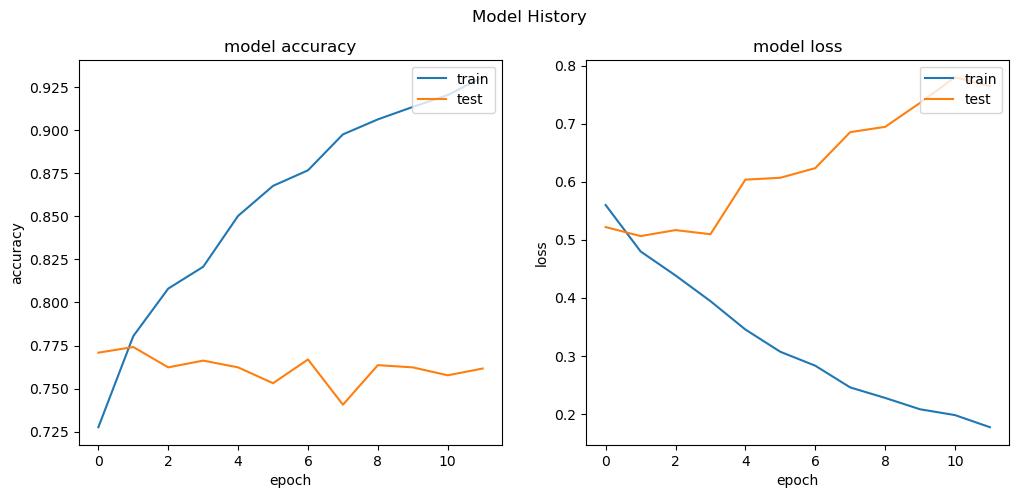

In [ ]:
model_history(history_CNN)

##  Training and Tuning Multi-Channel Convolutional Neural Network

In [ ]:
def MultichannelCNN(hp): 
    
    inputs1 = Input(shape=(length_long_sentence,))
    
    embedding1 = Embedding(vocab_length, 100, weights=[embedding_matrix],
                           input_length=length_long_sentence, trainable=False)(inputs1) 
    
    conv1 = Conv1D(filters=hp.Int('conv_1_filter',min_value=21,max_value=150,step=14),
                                kernel_size=hp.Choice('conv_1_kernel',values=[3,4,5,6,7,8]),
                                activation='relu')(embedding1) 
    
    drop1 = Dropout(0.3)(conv1) 
    
    pool1 = MaxPooling1D()(drop1) 
    
    flat1 = Flatten()(pool1)
    
    inputs2 = Input(shape=(length_long_sentence,)) 
    
    embedding2 = Embedding(vocab_length, 100, weights=[embedding_matrix],
                           input_length=length_long_sentence,trainable=False)(inputs2) 
    
    conv2 = Conv1D(filters=hp.Int('conv_2_filter',min_value=21,max_value=150,step=14),
                                kernel_size=hp.Choice('conv_2_kernel',values=[3,4,5,6,7,8]),
                                activation='relu')(embedding2) 
    
    drop2 = Dropout(0.3)(conv2) 
    
    pool2 = MaxPooling1D()(drop2) 
    
    flat2 = Flatten()(pool2) 
    
    # merge 
    merged = concatenate([flat1, flat2]) 
    
    dense1 = Dense(units = hp.Int('dense_1',min_value=21,max_value=120,step=14),
                               activation='relu')(merged)
    
    drop4 = Dropout(0.5)(dense1)
    
    outputs = Dense(1, activation='sigmoid')(drop4) 
    
    model = Model(inputs=[inputs1, inputs2], outputs=outputs) 
    
    hp_learning_rate = hp.Choice('learning_rate', values=[3e-2, 3e-3, 3e-4, 3e-5]) 
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
  
    return model

Creating a tuner using Keras-Tuner(kt) for above function, searching for best hyperparameters

In [ ]:
from tensorflow.keras.layers import Input, concatenate
from tensorflow.keras.models import Model


tuner_MCNN = kt.Hyperband(MultichannelCNN,objective='val_accuracy',
                          max_epochs=15,factor=5,
                          directory='my_dir',
                          project_name='DisasterTweetsMCNN_kt',
                          overwrite=True)

stop_early = EarlyStopping(monitor='val_loss', mode='min',
                           verbose=1, patience=10)

tuner_MCNN.search([X_train,X_train], y_train, epochs=15,
                  validation_data=([X_val,X_val], y_val),
                  callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps_MCNN=tuner_MCNN.get_best_hyperparameters(num_trials=1)[0]

Trial 13 Complete [00h 00m 57s]
val_accuracy: 0.7767564058303833

Best val_accuracy So Far: 0.7912015914916992
Total elapsed time: 00h 06m 18s


Creating a model for best found hyperparameters and training it

In [ ]:
model_MCNN = tuner_MCNN.hypermodel.build(best_hps_MCNN)

checkpoint = ModelCheckpoint(
    'model_MCNN.keras', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)

model_MCNN = tuner_MCNN.hypermodel.build(best_hps_MCNN)

history_MCNN = model_MCNN.fit([X_train,X_train], y_train,epochs=50,
                              validation_data=([X_val,X_val], y_val),
                              callbacks=[checkpoint,stop_early])

Epoch 1/50
186/191 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6805 - loss: 0.6028
Epoch 1: val_loss improved from inf to 0.50732, saving model to model_MCNN.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.6821 - loss: 0.6012 - val_accuracy: 0.7728 - val_loss: 0.5073
Epoch 2/50
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7935 - loss: 0.4687
Epoch 2: val_loss improved from 0.50732 to 0.50407, saving model to model_MCNN.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7934 - loss: 0.4687 - val_accuracy: 0.7702 - val_loss: 0.5041
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8175 - loss: 0.4114
Epoch 3: val_loss did not improve from 0.50407
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8175 - loss: 0.4114 - val_accuracy: 0.7820 - val_loss: 0.5243
Epoch 4/50
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8450 - loss: 0.3480
Epoch 4: val_loss did not improve from 0.50407
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/s

ploting model's summary

In [ ]:
model_MCNN.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 21)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 21)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 21, 100)   │  1,276,600 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 21, 100)   │  1,276,600 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 17, 147)   │     73,647 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 19, 63)    │     18,963 │ embedding_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 17, 147)   │          0 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 19, 63)    │          0 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 8, 147)    │          0 │ dropout_6[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 9, 63)     │          0 │ dropout_7[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 1176)      │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 567)       │          0 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 1743)      │          0 │ flatten_4[0][0],  │
│ (Concatenate)       │                   │            │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 49)        │     85,456 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 49)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         50 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,087,550 (11.78 MB)

 Trainable params: 178,116 (695.77 KB)

 Non-trainable params: 2,553,200 (9.74 MB)

 Optimizer params: 356,234 (1.36 MB)

ploting model training and validating history

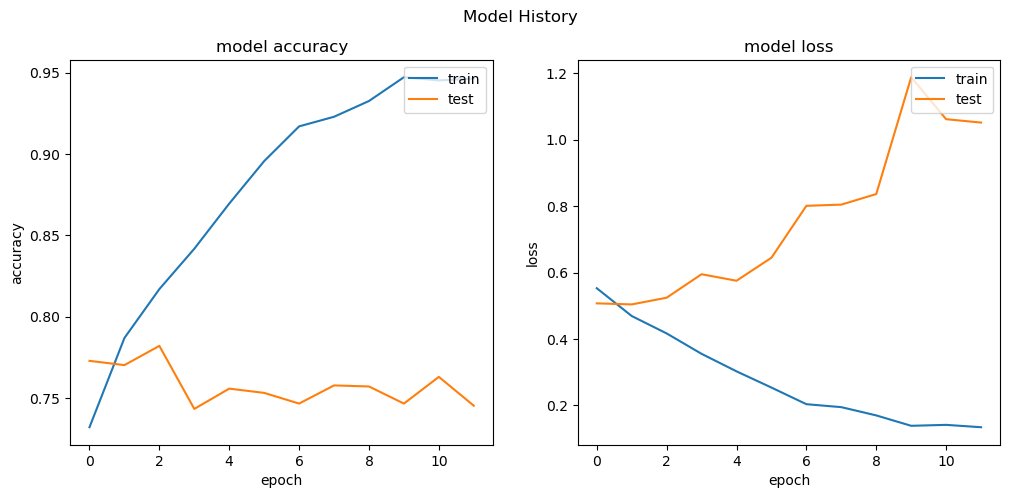

In [ ]:
model_history(history_MCNN)

## Training and Tuning Bidirectinal Long Short-Term Memory (LSTM) networks

In [33]:
def BiLSTM(hp):
    model = Sequential()
    
    model.add(Embedding(input_dim=embedding_matrix.shape[0], 
                        output_dim=embedding_matrix.shape[1], 
                        weights = [embedding_matrix], 
                        input_length=length_long_sentence,trainable = False))
    
    model.add(Bidirectional(LSTM(units = hp.Int('dense_1',
                                      min_value=21,max_value=120,step=14)
                                      ,return_sequences = True)))
    
    model.add(GlobalMaxPool1D())
   
    model.add(BatchNormalization())
    
    model.add(Dropout(0.2))
    
    model.add(Dense(units = hp.Int('dense_1',min_value=21,
                                   max_value=120,step=14),
                    activation = "relu"))
    
    model.add(Dropout(0.3))
    
    model.add(Dense(units = hp.Int('dense_1',min_value=21,
                                   max_value=100,step=14),
                    activation = "relu"))
    
    model.add(Dropout(0.5))
    
    model.add(Dense(1, activation = 'sigmoid'))
    
    hp_learning_rate = hp.Choice('learning_rate', 
                                 values=[3e-2, 3e-3, 3e-4, 3e-5]) 
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
  
    return model

Creating a tuner using Keras-Tuner(kt) for above function, searching for best hyperparameters

In [34]:
import keras_tuner as kt
from tensorflow.keras.preprocessing.text import Tokenizer


In [35]:
import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense, Dropout, Embedding, Conv1D, MaxPooling1D, Flatten, Input, Concatenate, Bidirectional, LSTM
from tensorflow.keras.layers import GlobalMaxPooling1D, BatchNormalization
from tensorflow.keras.layers import GlobalMaxPool1D

length_long_sentence = 50 # Example: Set to 50 words per sentence



tuner_BiLSTM = kt.Hyperband(BiLSTM,objective='val_accuracy',
                     max_epochs=15,factor=5,
                     directory='my_dir',
                     project_name='DisasterTweetsBiLSTM_kt',
                     overwrite=True)

stop_early = EarlyStopping(monitor='val_loss', mode='min',
                           verbose=1, patience=12)

tuner_BiLSTM.search(X_train, y_train, epochs=15,
                    validation_data=(X_val, y_val),
                    callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps_BiLSTM=tuner_BiLSTM.get_best_hyperparameters(num_trials=1)[0]

Trial 13 Complete [00h 01m 15s]
val_accuracy: 0.7025607228279114

Best val_accuracy So Far: 0.7931713461875916
Total elapsed time: 00h 11m 18s


Creating a model for best found hyperparameters and training it

In [ ]:
checkpoint = ModelCheckpoint(
    'model_BiLSTM.keras', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)

model_BiLSTM = tuner_BiLSTM.hypermodel.build(best_hps_BiLSTM)


history_BiLSTM = model_BiLSTM.fit(X_train, y_train, epochs=50,
                                  validation_data=(X_val, y_val),
                                  callbacks=[checkpoint,stop_early])

Epoch 1/50
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6138 - loss: 0.7011
Epoch 1: val_loss improved from inf to 0.61613, saving model to model_BiLSTM.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.6146 - loss: 0.7003 - val_accuracy: 0.7630 - val_loss: 0.6161
Epoch 2/50
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7198 - loss: 0.5647
Epoch 2: val_loss improved from 0.61613 to 0.52786, saving model to model_BiLSTM.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.7200 - loss: 0.5644 - val_accuracy: 0.7761 - val_loss: 0.5279
Epoch 3/50
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7489 - loss: 0.5232
Epoch 3: val_loss improved from 0.52786 to 0.49568, saving model to model_BiLSTM.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.7489 - loss: 0.5232 - val_accuracy: 0.7820 - val_loss: 0.4957
Epoch 4/50
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7662 - loss: 0.5056
Epoch 4: val_loss improved from 0.49568

printing model's summary

In [38]:
model_BiLSTM.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 21, 100)        │     1,276,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 21, 182)        │       139,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 182)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 182)            │           728 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 182)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 91)             │        16,653 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 91)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 91)             │         8,372 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 91)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            92 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,772,737 (6.76 MB)

 Trainable params: 165,257 (645.54 KB)

 Non-trainable params: 1,276,964 (4.87 MB)

 Optimizer params: 330,516 (1.26 MB)

ploting training and validation history of the model

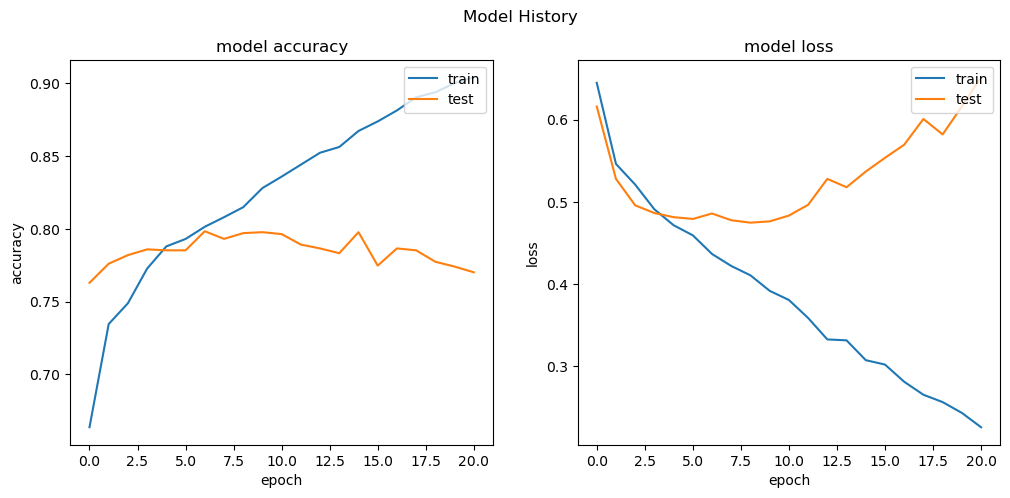

In [39]:
model_history(history_BiLSTM)

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

# Load the model
model = load_model("model_BiLSTM.keras")

# Initialize tokenizer (with same parameters used during training)
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")

# Fit tokenizer on some data
mock_data = ["Example disaster text", "Non-disaster example", "Fire in the building", "Great day ahead"]
tokenizer.fit_on_texts(mock_data)

# Test some examples
tweets = ["There is a massive fire in the city.", "Just saw a great movie!", "Disaster warning!"]
seq = tokenizer.texts_to_sequences(tweets)
padded_seq = pad_sequences(seq, maxlen=50, padding='post')

# Get predictions
predictions = model.predict(padded_seq)
print(predictions)



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step
[[0.96874255]
 [0.8747134 ]
 [0.4435209 ]]


In [ ]:
import matplotlib.pyplot as plt

# Assuming you've trained your model using X_train, y_train, X_val, y_val
# Now, we use `model_BiLSTM` to predict the probabilities on the validation set (or training set)
probs = model_BiLSTM.predict(X_val)  # Use X_val for validation data (or X_train for training data)

# Assuming the model outputs two probabilities: [prob_non_disaster, prob_disaster]
non_disaster_confidence = probs[:, 0]  # Probability for "non-disaster"
disaster_confidence = probs[:, 1]      # Probability for "disaster"

# Plot the histogram
plt.hist(disaster_confidence, bins=20, alpha=0.5, label="Disaster")
plt.hist(non_disaster_confidence, bins=20, alpha=0.5, label="Non-Disaster")
plt.legend()
plt.show()


NameError: name 'model_BiLSTM' is not defined